In [2]:
from flask import Flask, request, jsonify
import tensorflow as tf
import numpy as np
from werkzeug.utils import secure_filename
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt


2025-02-18 15:17:29.444390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 15:17:29.705455: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 15:17:29.707088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-18 15:17:30.830974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# flask initialize

app = Flask(__name__)   

config_file = '/home/shihas/Documents/DL/yolo/darknet/cfg/yolov3.cfg'
weights_file = '/home/shihas/Documents/DL/yolo/darknet/yolov3.weights'
names_file = '/home/shihas/Documents/DL/yolo/darknet/data/coco.names'

In [4]:
# load yolo model

net  = cv2.dnn.readNetFromDarknet(config_file, weights_file)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]



In [5]:
# load class names
class_names = []
with open("/home/shihas/Documents/DL/yolo/darknet/data/coco.names", "r") as f: 
    class_names = [line.strip() for line in f.readlines()]


In [6]:
# function to preprocess the image

def prepare_image(imge_path):
    img = cv2.imread(imge_path)
    img = cv2.resize(img, (416, 416))
    img = img / 255.0
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    return blob, img

In [7]:
# function to predict the image

def predict_yolo(image_path):
    img, blob = prepare_image(image_path)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # preocess results

    class_ids,confidences, boxes =[[],[],[]]
    height, width, channels = img.shape
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.3:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w // 2)
                y = int(center_y - h // 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # apply non max suppression
    # Apply Non-Max Suppression
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    predictions = []
    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            predictions.append({
                'label': class_names[class_ids[i]],
                'confidence': confidences[i],
                'box': [x, y, w, h]
            })


    return predictions, img



In [8]:
image_path = '/home/shihas/Documents/DL/yolo/car.jpg'
def prepare_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image at path: {image_path}")

    # Convert grayscale to RGB 
    if len(img.shape) == 2:  
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # Convert image to blob
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    return img, blob


In [9]:
# load and test

image_path = '/home/shihas/Documents/DL/yolo/car.jpg'
predictions, img = predict_yolo(image_path)
print(predictions)

[{'label': 'car', 'confidence': 0.9960050582885742, 'box': [1182, 877, 2871, 1729]}]


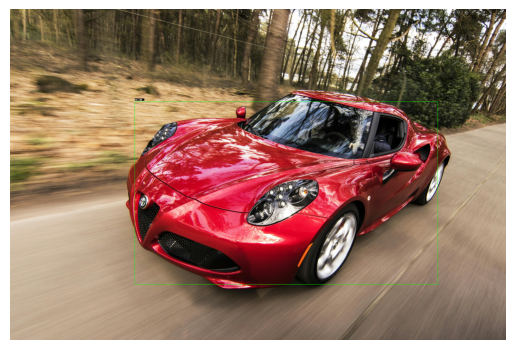

In [45]:
# Draw the bounding boxes and labels
for prediction in predictions:
    x, y, w, h = prediction['box']
    label = prediction['label']
    confidence = prediction['confidence']

    # Draw the bounding box
    color = (0, 255, 0)  # Green color for bounding box
    cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)

    # Position text correctly and ensure visibility
    text_x = max(0, x)
    text_y = max(20, y - 10)  # Ensure text is within bounds

    # Draw a background rectangle for the text (dark background for better contrast)
    label_text = f"{label} {confidence:.2f}"
    cv2.rectangle(img, (text_x, text_y - 20), (text_x + len(label_text) * 10 + 10, text_y), (0, 0, 0), -1)  # Darker background
    cv2.putText(img, label_text, (text_x, text_y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)  # White text

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show the image
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()
